Often times, when we take astronomical images, we have a small offset between individual images. There are several reasons for this. There are many imperfections that show up in any individual raw data frame -- hot pixels, cosmic rays, etc. To make sure we don't lose information / important parts of our objects, we deliberately add a small offset between images. This way, the astronomical target falls on different pixels so important objects are not always on bad pixels, etc. 

Before we can combine multiple frames into a single image, we'll need to shift and align the individual frames. That's the goal of this notebook. 

We'll look at a few different ways to approach this task, then compare them at the end. Often there are multiple valid ways to do something and often times there are good reasons to prefer some approaches to others. In this example, we'll keep track of the execution time (how long it takes the code to run) for a few different ways of coding the same basic task. 

## The input file

To make things easier, we will make an input file that has (1) the names of the images to align, (2) x shifts (in pixels), (3) the y shifts, (4) a representative value for the sky background, and (5) a scale factor so the counts are similar between all three images. The input file has the following format:

`#name     xsh   ysh   skyval   scale` <br>
`Vim1.fits  0   0   627  1`  <br> 
`Vim2.fits  20   -4   857   0.982`  <br> 
`Vim3.fits  0   15   912   1.099`  <br>

where the columns are: 
 - the image name
 - the xpixel shift
 - the ypixel shift
 - sky values
 - scale factor 
   
Note that the first line labels the columns. You can use commas or semicolons to separate the columns. Note that if you use whitespace, you must have the exact same number of spaces between columns or python will complain!


In [1]:
# start by importing the necessities 

from astropy.io import fits
from astropy.io import ascii
import warnings
import numpy as np
import matplotlib.pyplot as plt

#to keep track of the execution time
import time 

In [2]:
# files we need to do the alignment 

path = '/Users/mr82/teaching/data_for_ASTR230/reduced/'
flist='input_list_Vims.txt'
#images=ascii.read(path+flist,header_start=0,data_start=1,delimiter=" ") # reads flist into astropy table object `images'
images=ascii.read(path+flist,delimiter=" ") # reads flist into astropy table object `images'

## Image alignment using nested for loops

There are a few different ways to approach image alignment. You could use for loops to go through the configuration file and compute some offsets. Let's keep track of the execution time so we can compare approaches to image alignment at the end. 

In [3]:
nfiles=np.shape(images)[0] #number of files in the list
ixmax=np.zeros(nfiles, dtype=int)      #initialize these with zero
ixmin=np.zeros(nfiles, dtype=int)
iymin=np.zeros(nfiles, dtype=int)
iymax=np.zeros(nfiles, dtype=int)    

# collect the start time so we can see how long this takes to run
start_time = time.time()

#loop through the table to set limits and fix bad pixels for each file
for i in range(0,nfiles): 
    #read in the image 
    ffile=fits.open(path+images['name'][i]) 
    
    #read size of images from the header
    xsz=ffile[0].header['NAXIS1']
    ysz=ffile[0].header['NAXIS2']

    # collect shifts for each image 
    ixmin[i]=1+images['xsh'][i]  
    ixmax[i]=xsz+images['xsh'][i]
    iymin[i]=1+images['ysh'][i]  
    iymax[i]=ysz+images['ysh'][i]
    i+=1

# figure out the size of the composite image from the list of shifts 
ixmn=np.min(ixmin)
ixmx=np.max(ixmax)
iymn=np.min(iymin)
iymx=np.max(iymax)
ixbig=ixmx-ixmn+1 #size of composite
iybig=iymx-iymn+1   

# calculate and print the execution time 
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.003155946731567383 seconds ---


We can use this information to make a new 3-D array where we will insert the data in its correct, shifted position using a pair of nested for loops. 

In [4]:
#make an empty array for the combined image 
cgrid=np.empty((iybig,ixbig,nfiles))
#fill it with NaNs, then replace with data
cgrid[::]=np.NAN 


start_time = time.time()


#shift each image 
for i in range(0,nfiles): #loop through the files
    #read in the shifted data 
    ffile=fits.open(path+images['name'][i])
    fdata=ffile[0].data
    print("Doing image ",images['name'][i],end="")
    
    for iy in range(0,iybig):
        if(np.mod(iy,1+(iybig/20))==((iybig/20)-1)) :
            print("{0:s}Doing image {1:s} {2:2d}%".format('\r',images['name'][i],np.int(100*iy/iybig)),end="")
        #make sure each file contributes only where it has data
        if (iy<(iymin[i]-iymn) or iy>(iymax[i]-iymn)): 
            continue
        for ix in range(0,ixbig):
            if (ix<(ixmin[i]-ixmn) or ix>(ixmax[i]-ixmn)):
                continue
            #figure out the corresponding pixel index
            ky=iy-iymin[i]+iymn
            kx=ix-ixmin[i]+ixmn
            #pixel-by-pixel input into the array
            #omfg this is going to be sloooooooooooooooow 
            #add zeros on either side to shift, combine -- use to test speed of loops 

            # this also subtracts off the sky value and adds the multiplicative factor to the brightnesses are roughly equal 
            # we should take about whether this works for data where you care about the flux 
            cgrid[iy,ix,i] = (fdata[ky,kx]-images['skyval'][i])*images['scale'][i]
    ffile.close()
    print("{0:s}Doing image {1:s} ...done".format('\r',images['name'][i]))

print("--- %s seconds ---" % (time.time() - start_time))

Doing image m82_vim1.fits ...done
Doing image m82_vim2.fits ...done
Doing image m82_vim3.fits ...done
--- 7.282498121261597 seconds ---


Finally, we need to take the median of the image stack to make the combined image. This is again done in a pair of nested for loops. 

In [5]:
#make a new file to collect the combined image 
cfile=np.empty((iybig,ixbig))
cfile[:]=np.NAN 
print("Doing the composite median",end="")

start_time = time.time()

#a pixel-by-pixel median 
for ix in range(0,ixbig):
    if(np.mod(ix,1+(ixbig/20))==((ixbig/20)-1)) :
        print("{0:s}Doing the composite median {1:2d}%".format("\r",np.int(100*ix/ixbig)),end="")
    for iy in range(0,iybig):
        cfile[iy,ix]=np.nanmedian(cgrid[iy,ix,:])
print("{0:s}Doing the composite median  ...done".format("\r"))

print("--- %s seconds ---" % (time.time() - start_time))

Doing the composite median

/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_74898/4261289967.py:13: RuntimeWarning: All-NaN slice encountered
  cfile[iy,ix]=np.nanmedian(cgrid[iy,ix,:])


Doing the composite median  ...done
--- 26.24791383743286 seconds ---


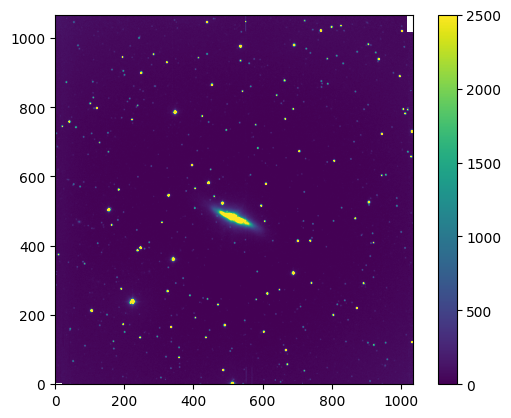

In [6]:
plt.imshow(cfile, origin='lower', vmin=0, vmax=2500)
plt.colorbar()

The code above uses a lot of for loops to combine the images and does a lot of the computations on a pixel-by-pixel basis. As you probably noticed, this doesn't run particularly fast. 

Fortunately, languages like python handle multi-dimensional arrays (like images and datacubes) well. With array manipulations, we can achieve the same basic tasks much more quickly. Let's take a look at how. 

## Image alignment using array manipulations 

The first few lines / steps will look similar. The following lines are written as if we are starting from the beginning but many of these numbers (e.g., xsz, ysz) will still be in memory. 

In [7]:
#read in the first image 
ffile=fits.open(path+images['name'][0]) #read size of images from the header
xsz=ffile[0].header['NAXIS1']
ysz=ffile[0].header['NAXIS2']

#compute min/max for each image 
ixmin=1+images['xsh']
ixmax=xsz+images['xsh']
iymin=1+images['ysh']
iymax=ysz+images['ysh']

# largest offset in every axis 
ixmn=np.min(1+images['xsh'])
ixmx=np.max(xsz+images['xsh'])
iymn=np.min(1+images['ysh'])
iymx=np.max(ysz+images['ysh']) 

#compute the shift needed for each image 
xshift=ixmn-ixmin
yshift=iymn-iymin


In [8]:
#make an empty array to collect the big, shifted images 
data_stack = []

start_time = time.time()

for i in range(0,nfiles): 
    #read in the image 
    ffile=fits.open(path+images['name'][i]) 
    fdata=(ffile[0].data - images['skyval'][i]) * images['scale'][i]

    # add NaNs around the edge of the image so we can shift the images without the data wrapping around on itself
    
    # make an array of NaNs to pad the x-axis 
    xedge = np.zeros((ysz,100)) + np.nan
    # add them on either side to make the image wider 
    bgim = np.hstack([xedge,fdata,xedge])

    # make an array of NaNs to pad the y-axis 
    yedge = np.zeros((100,xsz+200)) + np.nan
    # add them on either side to make the image taller 
    bgim = np.vstack([yedge,bgim,yedge])

    # shift the image -- make the x and y axes are correctly mapped! 
    # subtracting from the shift for image 1 to go in the right direction 
    shift_im = np.roll(bgim, ((xshift[0]-xshift[i]),(yshift[0]-yshift[i])), axis=(1,0))

    # add to the data stack 
    data_stack.append(shift_im)

# make it an array so we can do math on it 
data_stack = np.array(data_stack)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.05360698699951172 seconds ---


In [9]:
shift_im = np.roll(bgim, ((xshift[0]-xshift[i]),(yshift[0]-yshift[i])), axis=(1,0))

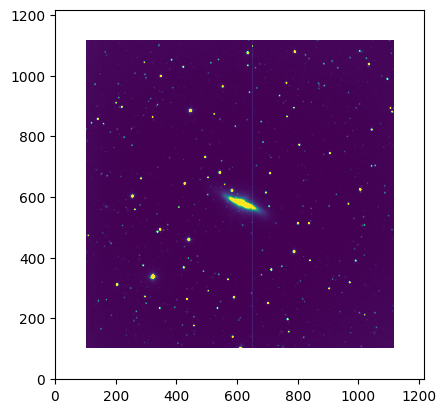

In [10]:
plt.imshow(data_stack[0], origin='lower', vmin=0, vmax=3000)

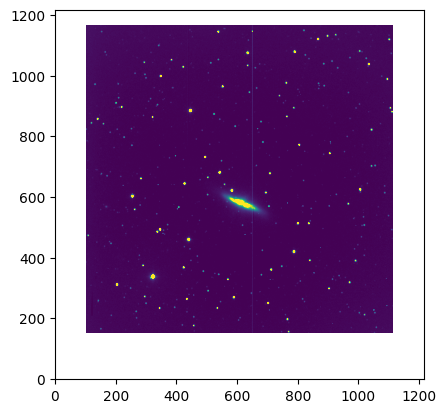

In [11]:
plt.imshow(data_stack[1], origin='lower', vmin=0, vmax=3000)

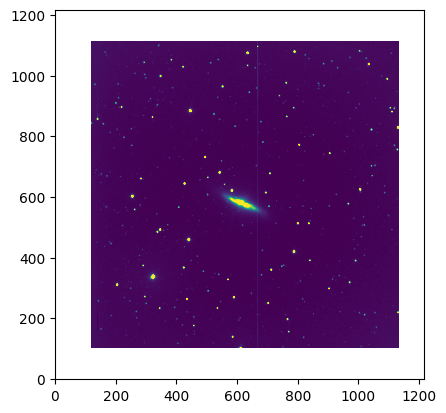

In [12]:
plt.imshow(data_stack[2], origin='lower', vmin=0, vmax=3000)

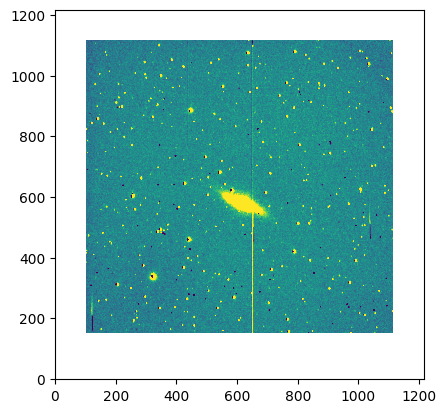

In [13]:
plt.imshow(data_stack[0]-data_stack[1], origin='lower', vmin=-100, vmax=100)

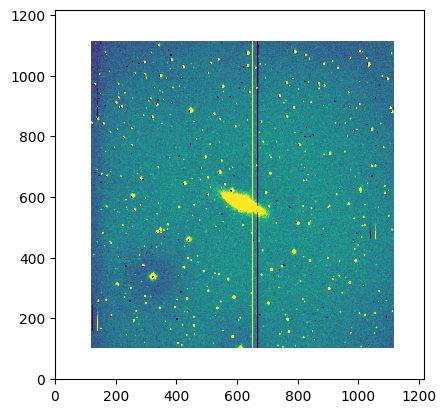

In [14]:
plt.imshow(data_stack[0]-data_stack[2], origin='lower', vmin=-100, vmax=100)

In [15]:
start_time = time.time()
# take the median of the image through the stack direction 
# notice that we use np.nanmedian() so that we get the correct medians even where there are NaNs 
imstack = np.nanmedian(data_stack, axis=0)
print("--- %s seconds ---" % (time.time() - start_time))

/var/folders/wk/v7gvg5m52lj_gc9jxn9tz8_r0000gn/T/ipykernel_74898/2957046369.py:4: RuntimeWarning: All-NaN slice encountered
  imstack = np.nanmedian(data_stack, axis=0)


--- 0.4887847900390625 seconds ---


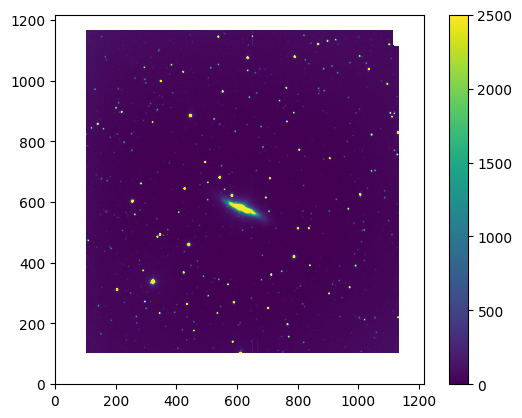

In [16]:
plt.Figure(figsize=(12,8))
plt.imshow(imstack, origin='lower', vmin=0, vmax=2500)
plt.colorbar()

At this point, you can trim the image to get rid of the extra NaNs around the edges. 